In [12]:
!pip install filterpy opencv-python ultralytics motmetrics --quiet

import os
import cv2
import numpy as np
import time
import pandas as pd
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from ultralytics import YOLO
import motmetrics as mm
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
model = YOLO('yolov8n.pt')

In [5]:
class KalmanBoxTracker:
    count = 0
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.array([[1,0,0,0,1,0,0],
                              [0,1,0,0,0,1,0],
                              [0,0,1,0,0,0,1],
                              [0,0,0,1,0,0,0],
                              [0,0,0,0,1,0,0],
                              [0,0,0,0,0,1,0],
                              [0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],
                              [0,1,0,0,0,0,0],
                              [0,0,1,0,0,0,0],
                              [0,0,0,1,0,0,0]])
        self.kf.R *= 10
        self.kf.P *= 10
        self.kf.Q *= 0.01
        self.kf.x[:4] = bbox.reshape((4,1))
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1

    def predict(self):
        self.kf.predict()
        self.time_since_update += 1
        return self.kf.x[:4].reshape((1, 4))

    def update(self, bbox):
        self.kf.update(bbox)
        self.time_since_update = 0

In [6]:
class Sort:
    def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []

    def update(self, detections):
        trks = np.zeros((len(self.trackers), 5))
        to_del = []
        for t, trk in enumerate(trks):
            pos = self.trackers[t].predict()[0]
            trk[:4] = pos
            trk[4] = 0
            if np.any(np.isnan(pos)):
                to_del.append(t)
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
            self.trackers.pop(t)

        matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(detections, trks, self.iou_threshold)

        for t, trk in enumerate(self.trackers):
            if t not in unmatched_trks:
                d = matched[np.where(matched[:,1]==t)[0],0]
                trk.update(detections[d[0]])

        for i in unmatched_dets:
            trk = KalmanBoxTracker(detections[i])
            self.trackers.append(trk)

        i = len(self.trackers)
        for trk in reversed(self.trackers):
            if trk.time_since_update > self.max_age:
                self.trackers.pop(i-1)
            i -= 1

        ret = []
        for trk in self.trackers:
            d = trk.kf.x
            ret.append(np.concatenate((d[:4].reshape(4), [trk.id+1])).reshape(1, -1))
        if len(ret) > 0:
            return np.concatenate(ret)
        return np.empty((0, 5))



In [7]:
def associate_detections_to_trackers(detections, trackers, iou_threshold=0.3):
    if len(trackers)==0:
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0),dtype=int)
    iou_matrix = np.zeros((len(detections),len(trackers)),dtype=np.float32)
    for d,det in enumerate(detections):
        for t,trk in enumerate(trackers):
            iou_matrix[d,t] = bbox_iou(det, trk)
    matched_indices = linear_sum_assignment(-iou_matrix)
    matched_indices = np.array(list(zip(*matched_indices)))
    unmatched_detections = []
    for d,det in enumerate(detections):
        if d not in matched_indices[:,0]:
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t,trk in enumerate(trackers):
        if t not in matched_indices[:,1]:
            unmatched_trackers.append(t)
    matches = []
    for m in matched_indices:
        if iou_matrix[m[0], m[1]] < iou_threshold:
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if len(matches) == 0:
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

def bbox_iou(bb_test,bb_gt):
    xx1 = np.maximum(bb_test[0], bb_gt[0])
    yy1 = np.maximum(bb_test[1], bb_gt[1])
    xx2 = np.minimum(bb_test[2], bb_gt[2])
    yy2 = np.minimum(bb_test[3], bb_gt[3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w*h
    o = wh / ((bb_test[2]-bb_test[0])*(bb_test[3]-bb_test[1]) +
              (bb_gt[2]-bb_gt[0])*(bb_gt[3]-bb_gt[1]) - wh)
    return(o)

In [31]:
def run_tracking_on_seq(dataset_path, sequence_name):
    image_files = sorted([os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')])

    print(f"Total {len(image_files)} frames found in the sequence.")

    tracker = Sort()

    tracking_outputs = []
    frame_count = 0
    start_time = time.time()

    for idx, image_path in enumerate(image_files):
        frame = cv2.imread(image_path)
        frame_count += 1

        # YOLOv8 detection
        detections = model.predict(frame, imgsz=640, conf=0.5)[0].boxes.xyxy.cpu().numpy()
        detection_boxes = []
        for det in detections:
            x1, y1, x2, y2 = det
            detection_boxes.append([x1, y1, x2, y2])
        detection_boxes = np.array(detection_boxes)

        # SORT tracking
        tracks = tracker.update(detection_boxes)

        # Draw tracking results

        for d in tracks:
            x1, y1, x2, y2, track_id = d
            width = x2 - x1
            height = y2 - y1
            tracking_outputs.append([idx+1, int(track_id), x1, y1, width, height])

            # Draw bounding box and ID
            p1 = (int(x1), int(y1))
            p2 = (int(x2), int(y2))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2)
            cv2.putText(frame, f'ID: {int(track_id)}', (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        if idx % 200 == 0:

          resized_frame = cv2.resize(frame, (640, 360))
          cv2_imshow(resized_frame)

    end_time = time.time()
    fps = frame_count / (end_time - start_time)
    print(f"Tracking completed. FPS: {fps:.2f}")

    # Save results
    tracking_outputs = np.array(tracking_outputs)
    output_path = f'/content/sort_tracking_{sequence_name}.txt'
    output_df = pd.DataFrame(tracking_outputs)
    output_df.to_csv(output_path, index=False, header=False)
    print(f"Tracking results saved to {output_path}")
    return output_path, fps

In [32]:
def bbox_iou_voc(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [33]:
# Load hypothesis
def result_sequence(sequence_name):
    print(f"Results for {sequence_name}:\n")
    gt_path = f'/content/drive/MyDrive/CMP719/MOT17/{sequence_name}/gt/gt.txt'
    gt = pd.read_csv(gt_path, header=None)
    gt.columns = ["frame", "id", "x", "y", "w", "h", "conf", "class", "vis"]

    # Filter valid objects (confidence = 1)
    gt = gt[gt['conf'] == 1]

    # Only keep necessary columns
    gt = gt[["frame", "id", "x", "y", "w", "h"]]


    hyp = pd.read_csv(f'/content/sort_tracking_{sequence_name}.txt', header=None)
    hyp = hyp.iloc[:, :6]
    hyp.columns = ["frame", "id", "x", "y", "w", "h"]

    total_gt = len(gt)
    false_positives = 0
    misses = 0
    id_switches = 0
    ious = []

    for frame_id in sorted(gt['frame'].unique()):
        gt_frame = gt[gt['frame'] == frame_id]
        hyp_frame = hyp[hyp['frame'] == frame_id]

        gt_boxes = gt_frame[["x", "y", "w", "h"]].values
        gt_ids = gt_frame["id"].values
        hyp_boxes = hyp_frame[["x", "y", "w", "h"]].values
        hyp_ids = hyp_frame["id"].values

        if len(gt_boxes) == 0 and len(hyp_boxes) == 0:
            continue

        iou_matrix = np.zeros((len(gt_boxes), len(hyp_boxes)))

        for i, gt_box in enumerate(gt_boxes):
            for j, hyp_box in enumerate(hyp_boxes):
                iou_matrix[i, j] = bbox_iou_voc(gt_box, hyp_box)

        matched_indices = linear_sum_assignment(-iou_matrix)
        matches = 0

        for gt_idx, hyp_idx in zip(*matched_indices):
            if iou_matrix[gt_idx, hyp_idx] >= 0.5:
                matches += 1
                ious.append(iou_matrix[gt_idx, hyp_idx])
            else:
                false_positives += 1
                misses += 1

        false_positives += len(hyp_boxes) - matches
        misses += len(gt_boxes) - matches

    # Calculate simple metrics
    mota = 1 - (false_positives + misses) / total_gt
    motp = np.mean(ious) if ious else 0

    print(f"MOTA (Simple): {mota:.4f}")
    print(f"MOTP (Simple IOU avg): {motp:.4f}")
    print()


In [34]:
dataset_path1 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-02-SDP/img1/'
dataset_path2 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-04-FRCNN/img1/'
dataset_path3 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-09-DPM/img1/'
dataset_path4 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-10-SDP/img1/'

Total 600 frames found in the sequence.

0: 384x640 5 persons, 129.6ms
Speed: 3.6ms preprocess, 129.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


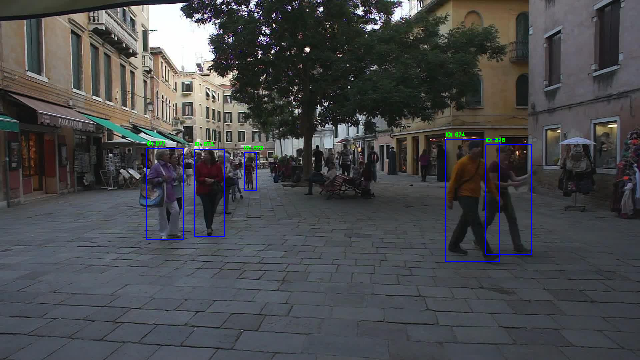


0: 384x640 5 persons, 147.4ms
Speed: 3.9ms preprocess, 147.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 128.5ms
Speed: 3.8ms preprocess, 128.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 126.4ms
Speed: 4.0ms preprocess, 126.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 124.7ms
Speed: 3.9ms preprocess, 124.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 148.0ms
Speed: 3.8ms preprocess, 148.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 275.3ms
Speed: 8.8ms preprocess, 275.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 136.2ms
Speed: 4.3ms preprocess, 136.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 128.3ms
Speed: 3.8ms preprocess, 128.3ms inference, 1.1ms postp

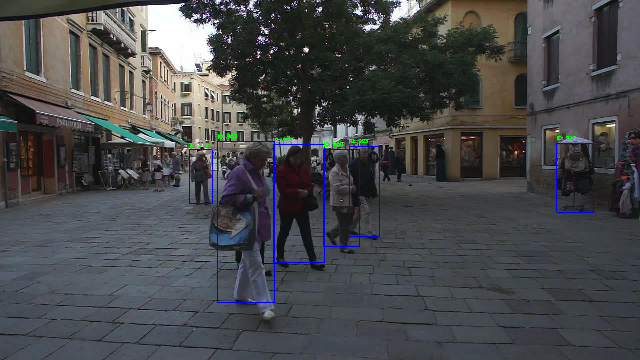


0: 384x640 5 persons, 153.2ms
Speed: 3.9ms preprocess, 153.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 133.0ms
Speed: 4.0ms preprocess, 133.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 145.2ms
Speed: 4.1ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 126.5ms
Speed: 3.9ms preprocess, 126.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 125.8ms
Speed: 4.0ms preprocess, 125.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 127.6ms
Speed: 4.4ms preprocess, 127.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 125.3ms
Speed: 4.1ms preprocess, 125.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.0ms
Speed: 4.2ms preprocess, 126.0ms inference, 1.2ms postprocess per 

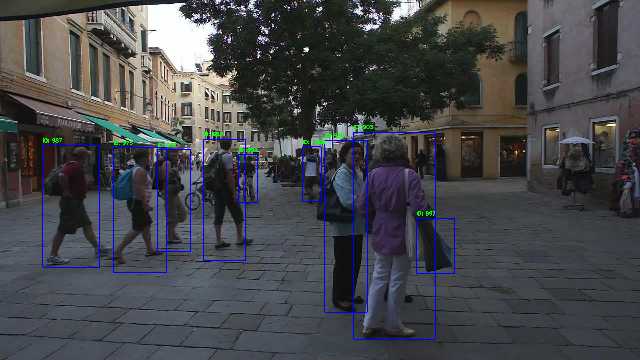


0: 384x640 7 persons, 206.7ms
Speed: 3.9ms preprocess, 206.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 200.0ms
Speed: 4.4ms preprocess, 200.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 194.7ms
Speed: 4.8ms preprocess, 194.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 214.7ms
Speed: 4.2ms preprocess, 214.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 199.7ms
Speed: 5.4ms preprocess, 199.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 188.4ms
Speed: 4.0ms preprocess, 188.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 198.9ms
Speed: 7.4ms preprocess, 198.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 228.8ms
Speed: 3.9ms preprocess, 228.8ms

In [35]:
tracking_file1, fps1 = run_tracking_on_seq(dataset_path1, 'MOT17-02-SDP')

In [36]:
tracking_file2, fps2 = run_tracking_on_seq(dataset_path2, 'MOT17-04-FRCNN')

Output hidden; open in https://colab.research.google.com to view.

Total 525 frames found in the sequence.

0: 384x640 6 persons, 127.6ms
Speed: 4.1ms preprocess, 127.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


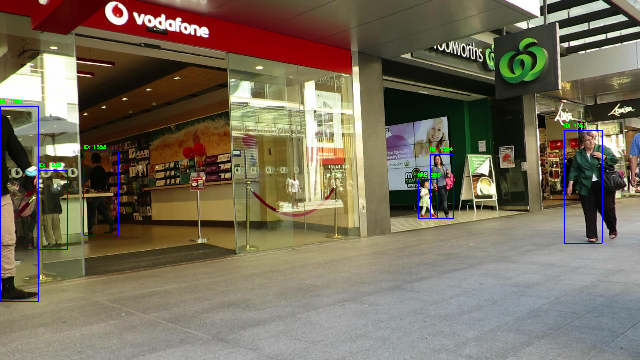


0: 384x640 8 persons, 125.2ms
Speed: 4.9ms preprocess, 125.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 128.5ms
Speed: 4.7ms preprocess, 128.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 126.5ms
Speed: 6.0ms preprocess, 126.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 126.4ms
Speed: 5.9ms preprocess, 126.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 294.2ms
Speed: 3.9ms preprocess, 294.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 219.1ms
Speed: 8.0ms preprocess, 219.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 222.7ms
Speed: 4.4ms preprocess, 222.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 217.8ms
Speed: 4.2ms preprocess, 217.8ms inference, 1.4ms postp

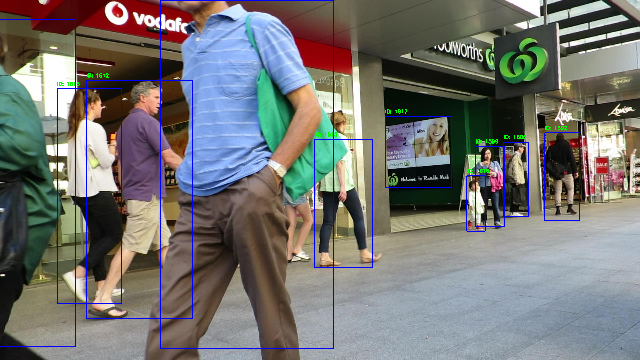


0: 384x640 10 persons, 156.2ms
Speed: 3.9ms preprocess, 156.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 128.8ms
Speed: 3.8ms preprocess, 128.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 136.0ms
Speed: 4.2ms preprocess, 136.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 138.5ms
Speed: 4.0ms preprocess, 138.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 131.4ms
Speed: 4.1ms preprocess, 131.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 150.6ms
Speed: 3.8ms preprocess, 150.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 131.9ms
Speed: 4.2ms preprocess, 131.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 135.1ms
Speed: 3.6ms preprocess, 135.1ms inferen

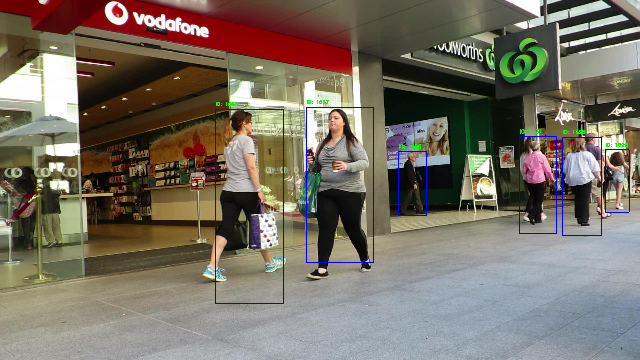


0: 384x640 6 persons, 149.1ms
Speed: 4.1ms preprocess, 149.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 189.4ms
Speed: 4.1ms preprocess, 189.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 233.4ms
Speed: 5.4ms preprocess, 233.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 191.6ms
Speed: 3.9ms preprocess, 191.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 209.1ms
Speed: 3.8ms preprocess, 209.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 201.9ms
Speed: 6.1ms preprocess, 201.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 handbags, 243.2ms
Speed: 3.8ms preprocess, 243.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 204.0ms
Speed: 8.9

In [37]:
tracking_file3, fps3 = run_tracking_on_seq(dataset_path3, 'MOT17-09-DPM')

Total 654 frames found in the sequence.

0: 384x640 7 persons, 1 truck, 124.0ms
Speed: 4.0ms preprocess, 124.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


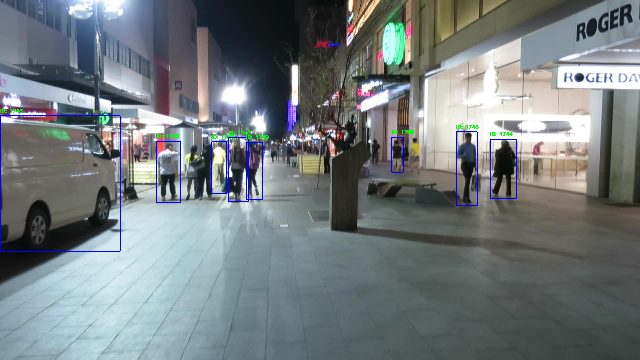


0: 384x640 6 persons, 124.7ms
Speed: 4.4ms preprocess, 124.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 truck, 124.5ms
Speed: 3.9ms preprocess, 124.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 123.8ms
Speed: 4.3ms preprocess, 123.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 124.2ms
Speed: 5.0ms preprocess, 124.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 145.6ms
Speed: 4.2ms preprocess, 145.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 143.4ms
Speed: 3.9ms preprocess, 143.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 129.3ms
Speed: 3.7ms preprocess, 129.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 truck, 127.9ms
Speed: 5.1ms preproce

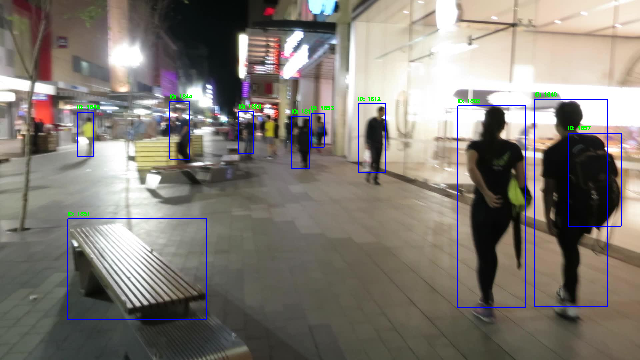


0: 384x640 4 persons, 1 bench, 1 backpack, 222.1ms
Speed: 4.0ms preprocess, 222.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 1 backpack, 220.6ms
Speed: 6.3ms preprocess, 220.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 1 backpack, 216.3ms
Speed: 4.1ms preprocess, 216.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bench, 211.3ms
Speed: 4.0ms preprocess, 211.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 225.7ms
Speed: 4.0ms preprocess, 225.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 252.8ms
Speed: 4.2ms preprocess, 252.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bench, 213.1ms
Speed: 3.8ms preprocess, 213.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640

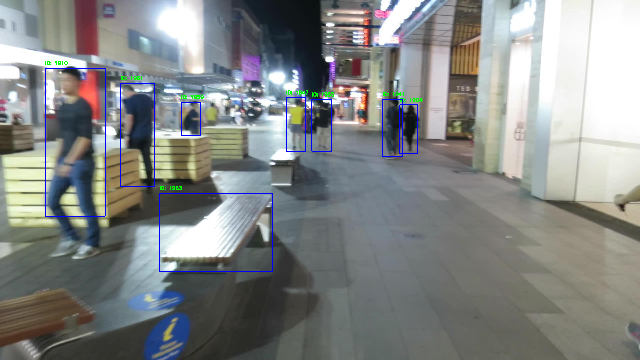


0: 384x640 8 persons, 1 bench, 145.7ms
Speed: 3.8ms preprocess, 145.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 134.3ms
Speed: 4.3ms preprocess, 134.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 136.9ms
Speed: 4.2ms preprocess, 136.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 152.4ms
Speed: 4.4ms preprocess, 152.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 140.9ms
Speed: 4.0ms preprocess, 140.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 138.7ms
Speed: 4.1ms preprocess, 138.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 136.6ms
Speed: 4.2ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 135.9ms
Speed: 4.1ms preproce

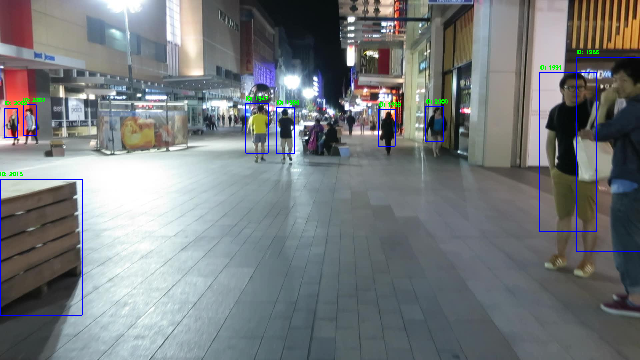


0: 384x640 8 persons, 1 bench, 153.7ms
Speed: 4.0ms preprocess, 153.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 164.2ms
Speed: 4.5ms preprocess, 164.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 142.0ms
Speed: 4.2ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 140.4ms
Speed: 4.1ms preprocess, 140.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bench, 140.9ms
Speed: 4.1ms preprocess, 140.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 140.4ms
Speed: 4.0ms preprocess, 140.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 147.3ms
Speed: 4.2ms preprocess, 147.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 160.5ms
Spe

In [38]:
tracking_file4, fps4 = run_tracking_on_seq(dataset_path4, 'MOT17-10-SDP')

In [39]:
result_sequence('MOT17-02-SDP')
result_sequence('MOT17-04-FRCNN')
result_sequence('MOT17-09-DPM')
result_sequence('MOT17-10-SDP')

Results for MOT17-02-SDP:

MOTA (Simple): 0.0818
MOTP (Simple IOU avg): 0.7989

Results for MOT17-04-FRCNN:

MOTA (Simple): 0.1395
MOTP (Simple IOU avg): 0.7775

Results for MOT17-09-DPM:

MOTA (Simple): 0.2616
MOTP (Simple IOU avg): 0.7887

Results for MOT17-10-SDP:

MOTA (Simple): 0.1042
MOTP (Simple IOU avg): 0.7187

